<a href="https://colab.research.google.com/github/soobook/PyTorch-DL/blob/main/code/PT09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 9회차: CNN을 활용한 컬러 이미지 분류 (3) – 모델 학습 및 평가

## 8회차 전체 코드

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),    # 데이터 증강
    transforms.RandomCrop(32, padding=4), # 데이터 증강
    transforms.ToTensor(),                # 데이터 스케일 조정
    transforms.Normalize((0.4914, 0.4822, 0.4465), # 데이터 정규화
                         (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

classes = trainset.classes

# 2. CNN 모델 정의
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.layer1 = nn.Sequential(
            # 채널 수, 출력 필터인 feature map 수, 커널(필터)의 크기, 패딩 픽셀 수
            # 내부적으로 (채널 수 × feature map 수) 만큼의 커널(필터)를 생성
            # nn.Conv2d(3, 32, 3, padding=1),
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),

            # 학습 중에 각 채널(feature map)의 평균과 분산을 정규화
            # 학습 안정화, 수렴 속도 증가, 과적합 방지 효과
            nn.BatchNorm2d(32),

            # 비선형 활성화 함수 (Rectified Linear Unit)
            # 음수는 0, 양수는 그대로 통과
            nn.ReLU(),

            # 2×2 크기의 창(window)을 사용해, 그 안에서 최댓값만 추출
            # 32×32 → 16×16로 줄어듦
            nn.MaxPool2d(2))

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # 16×16 → 8×8로 줄어듦
            nn.MaxPool2d(2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # 8×8 → 4×4로 줄어듦
            nn.MaxPool2d(2))

        self.fc = nn.Linear(128 * 4 * 4, 10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

100%|██████████| 170M/170M [00:03<00:00, 48.5MB/s]


## 1. CNN 구현(전체 중에 후반부)

In [ ]:
# 3. 모델 준비 및 구조 출력
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = SimpleCNN().to(device)
summary(net, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
         MaxPool2d-4           [-1, 32, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          18,496
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
         MaxPool2d-8             [-1, 64, 8, 8]               0
            Conv2d-9            [-1, 128, 8, 8]          73,856
      BatchNorm2d-10            [-1, 128, 8, 8]             256
             ReLU-11            [-1, 128, 8, 8]               0
        MaxPool2d-12            [-1, 128, 4, 4]               0
           Linear-13                   [-1, 10]          20,490
Total params: 114,186
Trainable params:

## CNN 학습

In [ ]:
# 4. 학습을 위한 손실함수와 옵티마이저 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# 학습 과정 시, 손실 값과 정확도를 저장할 변수 초기화
train_losses = []
test_accuracies = []

### 손실함수 nn.CrossEntropyLoss() 이해

In [ ]:
import torch
import torch.nn as nn

# 가짜 모델 출력 (logits)
logits = torch.tensor([[1.5, 2.0, 0.3],   # 샘플 1
                       [0.2, 2.4, 0.1]])  # 샘플 2

# 정답 라벨 (클래스 인덱스)
labels = torch.tensor([1, 1])  # 둘 다 class 1이 정답

# 손실 함수 선언 및 계산
criterion = nn.CrossEntropyLoss()
loss = criterion(logits, labels)

print("Loss:", loss.item())

Loss: 0.3866370618343353


In [ ]:
# 5. 학습 루프
epochs = 10 # 총 10번의 epoch 동안 반복
for epoch in range(epochs):
    net.train()  # 모델을 학습 모드로 설정 (Dropout, BatchNorm 등 활성화)
    running_loss = 0.0  # epoch 동안 손실값을 누적할 변수 초기화

    # 훈련 데이터(trainloader)에서 배치 단위로 반복
    for i, (inputs, labels) in enumerate(trainloader):
        # 입력 데이터와 정답 레이블을 GPU 또는 CPU로 이동
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()     # 이전에 계산된 gradient를 초기화
        outputs = net(inputs)     # 모델에 입력을 넣고 예측값 출력
        loss = criterion(outputs, labels)  # 손실(loss) 계산
        loss.backward()           # 역전파로 gradient 계산
        optimizer.step()          # gradient를 사용해 모델 파라미터 업데이트
        running_loss += loss.item()  # 배치 손실값을 누적 (float 값)

    # epoch별 평균 손실값 계산
    avg_loss = running_loss / len(trainloader)
    train_losses.append(avg_loss)  # 그래프 시각화 등을 위한 손실 기록

    # 평가 모드로 전환 (Dropout, BatchNorm 등 비활성화)
    net.eval()
    correct = 0  # 맞힌 샘플 수
    total = 0    # 전체 샘플 수

    # 테스트 시에는 gradient 계산 필요 없음 → 연산 효율 높임
    with torch.no_grad():
        # 테스트 데이터셋에서 배치 단위로 평가
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)  # 모델 예측
            _, predicted = torch.max(outputs, 1)  # 가장 높은 확률을 가진 클래스 선택
            total += labels.size(0)  # 총 정답 수 누적
            correct += (predicted == labels).sum().item()  # 맞힌 개수 누적

    # 정확도(%) 계산
    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)  # 정확도 기록

    # epoch 결과 출력
    print(f'[Epoch {epoch+1}] Loss: {avg_loss:.3f} | Test Accuracy: {accuracy:.2f}%')

[Epoch 1] Loss: 1.387 | Test Accuracy: 61.53%
[Epoch 2] Loss: 1.030 | Test Accuracy: 66.44%
[Epoch 3] Loss: 0.912 | Test Accuracy: 68.67%
[Epoch 4] Loss: 0.847 | Test Accuracy: 73.22%
[Epoch 5] Loss: 0.801 | Test Accuracy: 74.53%
[Epoch 6] Loss: 0.755 | Test Accuracy: 74.22%
[Epoch 7] Loss: 0.721 | Test Accuracy: 72.89%
[Epoch 8] Loss: 0.691 | Test Accuracy: 75.98%
[Epoch 9] Loss: 0.666 | Test Accuracy: 78.51%
[Epoch 10] Loss: 0.653 | Test Accuracy: 79.43%


#### torch.max() 샘플 코드

In [ ]:
x = torch.tensor([1, 5, 3])
max_value = torch.max(x)
print(max_value)  # tensor(5)

tensor(5)


In [ ]:
x = torch.tensor([
    [1, 5, 2],
    [8, 3, 7]
])
values, indices = torch.max(x, dim=1)
print(values)   # tensor([5, 8]) → 각 행의 최댓값
print(indices)  # tensor([1, 0]) → 각 행에서 최댓값이 있는 열 인덱스

tensor([5, 8])
tensor([1, 0])


In [ ]:
import torch

# 예: 모델의 예측 결과 (batch_size=3, num_classes=4)
outputs = torch.tensor([
    [0.1, 0.2, 0.6, 0.1],   # 샘플 0 → class 2
    [0.8, 0.1, 0.05, 0.05], # 샘플 1 → class 0
    [0.3, 0.4, 0.1, 0.2]    # 샘플 2 → class 1
])

# 각 행(샘플)에서 가장 큰 값의 인덱스를 가져옴
_, predicted = torch.max(outputs, 1)

print("Outputs:\n", outputs)
print("Predicted class indices:", predicted)
print("variable _:", _)

Outputs:
 tensor([[0.1000, 0.2000, 0.6000, 0.1000],
        [0.8000, 0.1000, 0.0500, 0.0500],
        [0.3000, 0.4000, 0.1000, 0.2000]])
Predicted class indices: tensor([2, 0, 1])
variable _: tensor([0.6000, 0.8000, 0.4000])


## CNN 평가

In [ ]:
# 6. 테스트 정확도 및 예측 수집
# 모델을 평가 모드로 설정 (Dropout, BatchNorm 비활성화)
net.eval()

# 정확도 계산을 위한 변수 초기화
correct = 0  # 맞힌 개수
total = 0    # 전체 테스트 샘플 수

# 결과 시각화를 위한 리스트들
all_preds = []   # 예측된 레이블 저장용
all_images = []  # 이미지 데이터 저장용
all_labels = []  # 실제 정답 저장용

# gradient 계산은 하지 않도록 설정 → 속도 ↑, 메모리 ↓
with torch.no_grad():
    # 테스트 데이터셋을 배치 단위로 평가
    for inputs, labels in testloader:
        # 입력과 레이블을 CPU 또는 GPU로 이동
        inputs, labels = inputs.to(device), labels.to(device)

        # 모델에 입력을 넣고 출력(예측값) 계산
        # outputs 크기: [batch_size, num_classes]
        outputs = net(inputs)

        # 가장 높은 확률값을 갖는 클래스 인덱스를 예측값으로 선택
        # _는 최대 확률값 (사용하지 않음), predicted는 클래스 인덱스
        _, predicted = torch.max(outputs, 1)
        # 전체 수와 맞힌 수 누적
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # 결과 저장 (CPU로 이동한 뒤 numpy나 텐서로 저장)
        all_preds.extend(predicted.cpu().numpy())
        all_images.extend(inputs.cpu())
        all_labels.extend(labels.cpu())

# 최종 정확도 출력
print(f'Test Accuracy: {100 * correct / total:.2f}%')

Test Accuracy: 79.43%


### 데이터 시각화

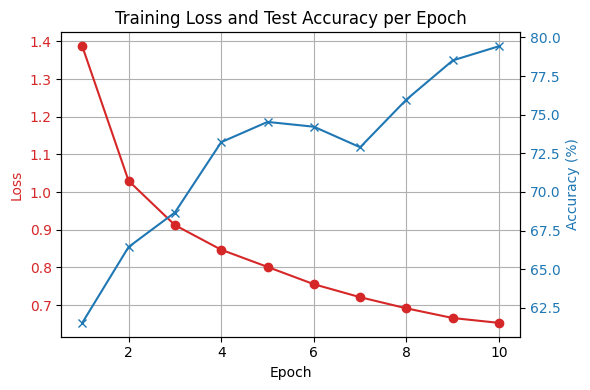

In [ ]:
# matplotlib 라이브러리에서 그래프를 그리기 위한 pyplot 모듈 임포트
import matplotlib.pyplot as plt

# 손실과 정확도를 함께 시각화하는 함수 정의
def plot_loss_and_accuracy_together(train_losses, test_accuracies):
    # 에폭 번호 리스트 생성 (1부터 시작)
    epochs = range(1, len(train_losses) + 1)

    # 하나의 figure와 기본 축(ax1)을 생성 (그래프 크기는 6x4인치)
    fig, ax1 = plt.subplots(figsize=(6, 4))

    # === 왼쪽 Y축: 손실(Loss) ===
    color = 'tab:red'  # 손실 곡선은 빨간색으로
    ax1.set_xlabel('Epoch')  # X축 라벨: 에폭 번호
    ax1.set_ylabel('Loss', color=color)  # 왼쪽 Y축 라벨: 손실값
    ax1.plot(epochs, train_losses, color=color, marker='o', label='Loss')  # 손실 곡선 그리기 (동그라미 마커 사용)
    ax1.tick_params(axis='y', labelcolor=color)  # 왼쪽 Y축 눈금 색상도 빨간색으로
    ax1.grid(True)  # 배경에 그리드 표시 (보기 편하게)

    # === 오른쪽 Y축: 정확도(Accuracy) ===
    ax2 = ax1.twinx()  # ax1과 X축을 공유하는 새로운 Y축 생성
    color = 'tab:blue'  # 정확도 곡선은 파란색으로
    ax2.set_ylabel('Accuracy (%)', color=color)  # 오른쪽 Y축 라벨
    ax2.plot(epochs, test_accuracies, color=color, marker='x', label='Accuracy')  # 정확도 곡선 그리기 (X 마커 사용)
    ax2.tick_params(axis='y', labelcolor=color)  # 오른쪽 Y축 눈금 색상 파란색

    # 전체 그래프 제목 설정
    plt.title('Training Loss and Test Accuracy per Epoch')

    # 레이아웃 자동 조정 (레이블 겹침 방지)
    fig.tight_layout()

    # 최종 그래프 화면에 출력
    plt.show()

# 함수 호출: 손실과 정확도 그래프 그리기
plot_loss_and_accuracy_together(train_losses, test_accuracies)

### CNN 결과 시각화

In [ ]:
# 7. 이미지 복원 및 시각화 함수 정의
def imshow(img):
    # CIFAR-10 데이터셋에 적용된 정규화를 복원 (역정규화)
    mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
    std = torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1)
    img = img * std + mean  # 정규화 반대로 되돌리기

    # 텐서를 numpy로 변환하고 픽셀 값 범위를 0~1로 제한
    img = img.numpy()
    img = np.clip(img, 0, 1)

    # (채널, 높이, 너비) → (높이, 너비, 채널) 로 차원 전환 후 이미지 출력
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.axis('off')  # 축은 생략

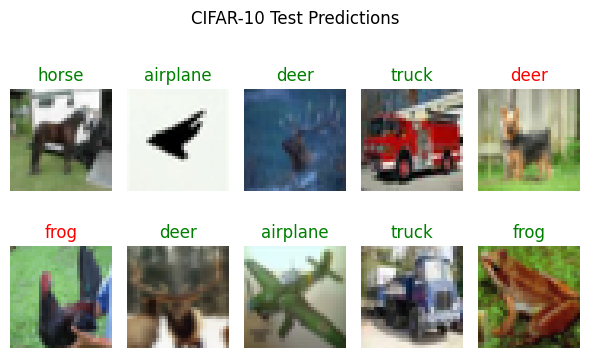

In [ ]:
# 8. 예측 결과 시각화 (앞에서 가져온 이미지 중 10개만)
fig = plt.figure(figsize=(6, 4))  # 전체 출력 이미지 크기 설정

# 예측을 점검을 시작 첨자 설정, 0, 10, 20, ... 등 설저
start_idx = 20
for idx in range(10):
    # 2행 5열의 서브플롯에 이미지 추가
    ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])

    # idx번째 이미지 출력
    idx = idx + start_idx
    imshow(all_images[idx])

    # 예측 라벨을 이미지 상단에 표시
    ax.set_title(
        f"{classes[all_preds[idx]]}",
        # 정답이면 초록, 오답이면 빨강
        color=('green' if all_preds[idx]==all_labels[idx] else 'red')
    )

# 전체 타이틀 및 레이아웃 정리
plt.suptitle("CIFAR-10 Test Predictions")
plt.tight_layout()
plt.show()

In [ ]:
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

### 다음은 9강 전체 코드

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary

# 1. CIFAR-10 데이터 전처리
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),    # 데이터 증강
    transforms.RandomCrop(32, padding=4), # 데이터 증강
    transforms.ToTensor(),                # 데이터 스케일 조정
    transforms.Normalize((0.4914, 0.4822, 0.4465), # 데이터 정규화
                         (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

classes = trainset.classes

# 2. CNN 모델 정의
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.layer1 = nn.Sequential(
            # 채널 수, 출력 필터인 feature map 수, 커널(필터)의 크기, 패딩 픽셀 수
            # 내부적으로 (채널 수 × feature map 수) 만큼의 커널(필터)를 생성
            # nn.Conv2d(3, 32, 3, padding=1),
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),

            # 학습 중에 각 채널(feature map)의 평균과 분산을 정규화
            # 학습 안정화, 수렴 속도 증가, 과적합 방지 효과
            nn.BatchNorm2d(32),

            # 비선형 활성화 함수 (Rectified Linear Unit)
            # 음수는 0, 양수는 그대로 통과
            nn.ReLU(),

            # 2×2 크기의 창(window)을 사용해, 그 안에서 최댓값만 추출
            # 32×32 → 16×16로 줄어듦
            nn.MaxPool2d(2))

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # 16×16 → 8×8로 줄어듦
            nn.MaxPool2d(2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # 8×8 → 4×4로 줄어듦
            nn.MaxPool2d(2))

        self.fc = nn.Linear(128 * 4 * 4, 10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

# 3. 모델 준비 및 구조 출력
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = SimpleCNN().to(device)
summary(net, (3, 32, 32))

# 4. 학습을 위한 손실함수와 옵티마이저 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# 학습 과정 시, 손실 값과 정확도를 저장할 변수 초기화
train_losses = []
test_accuracies = []

# 5. 학습 루프
epochs = 10 # 총 10번의 epoch 동안 반복
for epoch in range(epochs):
    net.train()  # 모델을 학습 모드로 설정 (Dropout, BatchNorm 등 활성화)
    running_loss = 0.0  # epoch 동안 손실값을 누적할 변수 초기화

    # 훈련 데이터(trainloader)에서 배치 단위로 반복
    for i, (inputs, labels) in enumerate(trainloader):
        # 입력 데이터와 정답 레이블을 GPU 또는 CPU로 이동
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()     # 이전에 계산된 gradient를 초기화
        outputs = net(inputs)     # 모델에 입력을 넣고 예측값 출력
        loss = criterion(outputs, labels)  # 손실(loss) 계산
        loss.backward()           # 역전파로 gradient 계산
        optimizer.step()          # gradient를 사용해 모델 파라미터 업데이트
        running_loss += loss.item()  # 배치 손실값을 누적 (float 값)

    # epoch별 평균 손실값 계산
    avg_loss = running_loss / len(trainloader)
    train_losses.append(avg_loss)  # 그래프 시각화 등을 위한 손실 기록

    # 평가 모드로 전환 (Dropout, BatchNorm 등 비활성화)
    net.eval()
    correct = 0  # 맞힌 샘플 수
    total = 0    # 전체 샘플 수

    # 테스트 시에는 gradient 계산 필요 없음 → 연산 효율 높임
    with torch.no_grad():
        # 테스트 데이터셋에서 배치 단위로 평가
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)  # 모델 예측
            _, predicted = torch.max(outputs, 1)  # 가장 높은 확률을 가진 클래스 선택
            total += labels.size(0)  # 총 정답 수 누적
            correct += (predicted == labels).sum().item()  # 맞힌 개수 누적

    # 정확도(%) 계산
    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)  # 정확도 기록

    # epoch 결과 출력
    print(f'[Epoch {epoch+1}] Loss: {avg_loss:.3f} | Test Accuracy: {accuracy:.2f}%')

# 6. 테스트 정확도 및 예측 수집
# 모델을 평가 모드로 설정 (Dropout, BatchNorm 비활성화)
net.eval()

# 정확도 계산을 위한 변수 초기화
correct = 0  # 맞힌 개수
total = 0    # 전체 테스트 샘플 수

# 결과 시각화를 위한 리스트들
all_preds = []   # 예측된 레이블 저장용
all_images = []  # 이미지 데이터 저장용
all_labels = []  # 실제 정답 저장용

# gradient 계산은 하지 않도록 설정 → 속도 ↑, 메모리 ↓
with torch.no_grad():
    # 테스트 데이터셋을 배치 단위로 평가
    for inputs, labels in testloader:
        # 입력과 레이블을 CPU 또는 GPU로 이동
        inputs, labels = inputs.to(device), labels.to(device)

        # 모델에 입력을 넣고 출력(예측값) 계산
        outputs = net(inputs)

        # 가장 높은 확률값을 갖는 클래스 인덱스를 예측값으로 선택
        _, predicted = torch.max(outputs, 1)

        # 전체 수와 맞힌 수 누적
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # 결과 저장 (CPU로 이동한 뒤 numpy나 텐서로 저장)
        all_preds.extend(predicted.cpu().numpy())
        all_images.extend(inputs.cpu())
        all_labels.extend(labels.cpu())

# 최종 정확도 출력
print(f'Test Accuracy: {100 * correct / total:.2f}%')

# 7. 이미지 복원 및 시각화 함수 정의
def imshow(img):
    # CIFAR-10 데이터셋에 적용된 정규화를 복원 (역정규화)
    mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
    std = torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1)
    img = img * std + mean  # 정규화 반대로 되돌리기

    # 텐서를 numpy로 변환하고 픽셀 값 범위를 0~1로 제한
    img = img.numpy()
    img = np.clip(img, 0, 1)

    # (채널, 높이, 너비) → (높이, 너비, 채널) 로 차원 전환 후 이미지 출력
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.axis('off')  # 축은 생략

# 8. 예측 결과 시각화 (앞에서 가져온 이미지 중 10개만)
fig = plt.figure(figsize=(6, 4))  # 전체 출력 이미지 크기 설정
for idx in range(10):
    # 2행 5열의 서브플롯에 이미지 추가
    ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])

    # idx번째 이미지 출력
    imshow(all_images[idx])

    # 예측 라벨을 이미지 상단에 표시
    ax.set_title(
        f"{classes[all_preds[idx]]}",
        color=('green' if all_preds[idx]==all_labels[idx] else 'red')  # 정답이면 초록, 오답이면 빨강
    )

# 전체 타이틀 및 레이아웃 정리
plt.suptitle("CIFAR-10 Test Predictions")
plt.tight_layout()
plt.show()

## 종료